## ECE495 Final Project: SNN and DNN on heart failure classification

Description here

#### Set up

**Ensure you are using your [495 Virtual Environment](https://github.com/kaitlin-fair/495venv_setup) before you begin!**  
    
Import Nengo and other supporting libraries into your program to get started:

In [107]:
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
import tensorflow as tf
import nengo_dl
import nengo
from nengo.processes import Piecewise
from nengo.processes import WhiteSignal
from nengo.solvers import LstsqL2
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report

### Datasets

Links and description

**load them below**


In [118]:
# # Specify training data
# file_name = "./heart.csv"

# # Read the CSV file into a DataFrame
# df = pd.read_csv(file_name)


# # extract training data
# y = df["output"]
# X = df.drop(columns="output")
file_name = "./heart3.csv"

# Read the CSV file into a DataFrame
df = pd.read_csv(file_name)


# extract training data
y = df["target"]
X = df.drop(columns="target")

### Preprocessing
`Standardization` is a preprocessing technique that rescales the features so that they have the properties of a `standard normal distribution with a mean of 0 and a standard deviation of 1`. This is important in machine learning because it ensures that the features are on a similar scale, preventing some features from dominating the learning process simply because they have larger magnitudes.

The `StandardScaler` in scikit-learn works by calculating the mean and standard deviation of each feature in the training set and then transforming the data based on these statistics. The formula for standardization is:

$$ Standardized Value = \frac{Original Value − Mean}{ Standard Deviation}$$

The purpose of standardization is to make the features of the dataset comparable and to ensure that they all contribute equally to the model training. It is particularly important when working with algorithms that are sensitive to the scale of the input features, such as gradient-based optimization algorithms used in neural networks.

In [119]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
# split
train_images, test_images, train_labels, test_labels = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### DNN
4 128 Neuron layers, Dropout of .03, 4 64 neuron layers, final layer with sigmoid activation


In [120]:
from keras import layers

model = tf.keras.models.Sequential(
    [
        layers.Dense(64, activation="relu", name="Dense1"),
        # layers.Dense(128, activation="relu", name="Dens2"),
        # layers.Dense(128, activation="relu", name="Dense3"),
        # layers.Dense(128, activation="relu", name="Dense4"),
        layers.Dropout(0.03),
        layers.Dense(64, activation="relu", name="Dense5"),
        # layers.Dense(64, activation="relu", name="Dense6"),
        # layers.Dense(64, activation="relu", name="Dense7"),
        # layers.Dense(64, activation="relu", name="Dense8"),
        layers.Dense(2, activation="sigmoid", name="Final"),
    ]
)

# Compile
model.compile(
    optimizer="Adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

# Train
model.fit(train_images, train_labels, epochs=100)

# Eval
model.evaluate(test_images, test_labels, verbose=2)

# Predict
probability_model = tf.keras.Sequential([model, layers.Softmax()])
predictions = probability_model.predict(test_images)

# Analyze
predictions2 = np.argmax(predictions, axis=1)

rpt = classification_report(test_labels, predictions2)
print(rpt)

Epoch 1/100


c:\Users\C24Ryan.Lilly\Documents\ECE\448\envs\495venv\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


8/8 [==============================] - 1s 6ms/step - loss: 0.6965 - accuracy: 0.5372
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 0.5749 - accuracy: 0.7521
Epoch 3/100
8/8 [==============================] - 0s 6ms/step - loss: 0.4911 - accuracy: 0.8140
Epoch 4/100
8/8 [==============================] - 0s 7ms/step - loss: 0.4336 - accuracy: 0.8347
Epoch 5/100
8/8 [==============================] - 0s 7ms/step - loss: 0.4004 - accuracy: 0.8512
Epoch 6/100
8/8 [==============================] - 0s 7ms/step - loss: 0.3643 - accuracy: 0.8678
Epoch 7/100
8/8 [==============================] - 0s 6ms/step - loss: 0.3514 - accuracy: 0.8719
Epoch 8/100
8/8 [==============================] - 0s 6ms/step - loss: 0.3276 - accuracy: 0.8760
Epoch 9/100
8/8 [==============================] - 0s 6ms/step - loss: 0.3215 - accuracy: 0.8760
Epoch 10/100
8/8 [==============================] - 0s 6ms/step - loss: 0.3037 - accuracy: 0.8967
Epoch 11/100
8/8 [=======================

### SNN
SNN for classification. Second since to avoid the timestep adding messing up the DNN. Same neuron configuration as the DNN.


Timestep processing breaks the nengo code because once the to_numpy commands have run they can't run on the arrays. So it gets its own block now

In [138]:
# #MNIST
# (train_images, train_labels), (
#     test_images,
#     test_labels,
# ) = tf.keras.datasets.mnist.load_data()
# train_images = np.reshape(train_images, (60000, 784))
# test_images = np.reshape(test_images, (10000, 784))


# # Timestep processing# Specify training data
file_name = "./heart3.csv"

# Read the CSV file into a DataFrame
df = pd.read_csv(file_name)


# extract training data
y = df["target"]
X = df.drop(columns="target")
# scaler = MinMaxScaler()
scaler2 = StandardScaler()
X = scaler2.fit_transform(X)
# X= scaler.fit_transform(X)
# split
train_images, test_images, train_labels, test_labels = train_test_split(
    X, y, test_size=0.2, random_state=42
)
train_images = train_images / np.max(train_images)
test_images = test_images / np.max(test_images)

n_steps = 100
# test_images = test_images.to_numpy()
# train_images = train_images.to_numpy()
test_labels = test_labels.to_numpy()
train_labels = train_labels.to_numpy()
test_images = np.tile(test_images[:, None, :], (1, n_steps, 1))
test_labels = np.tile(test_labels[:, None, None], (1, n_steps, 1))
train_images = train_images[:, None, :]
train_labels = train_labels[:, None, None]
test_size = np.shape(test_images)[0]
print(np.shape(test_images))
print(np.shape(test_labels))

(205, 100, 13)
(205, 100, 1)


In [141]:
with nengo.Network(seed=0) as net:
    net.config[nengo.Ensemble].max_rates = nengo.dists.Choice([100])
    net.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    net.config[nengo.Connection].synapse = None
    neuron_type = nengo.LIF(amplitude=0.01)
    nengo_dl.configure_settings(stateful=False)

    inp = nengo.Node(np.zeros(train_images.shape[2]))

    # First dense layer
    d1 = nengo_dl.Layer(tf.keras.layers.Dense(64, activation="relu", name="Dense1"))(
        inp
    )
    d1 = nengo_dl.Layer(neuron_type)(d1)
    # d2 = nengo_dl.Layer(tf.keras.layers.Dense(128, activation="relu", name="Dense2"))(
    #     d1
    # )
    # d2 = nengo_dl.Layer(neuron_type)(d2)
    # d3 = nengo_dl.Layer(tf.keras.layers.Dense(128, activation="relu", name="Dense3"))(
    #     d2
    # )
    # d3 = nengo_dl.Layer(neuron_type)(d3)
    # d4 = nengo_dl.Layer(tf.keras.layers.Dense(128, activation="relu", name="Dense4"))(
    #     d3
    # )
    # d4 = nengo_dl.Layer(neuron_type)(d4)

    # Dropout layer
    drop1 = nengo_dl.Layer(tf.keras.layers.Dropout(0.03))(d1)
    drop1 = nengo_dl.Layer(neuron_type)(drop1)

    # Second dense layer
    d5 = nengo_dl.Layer(tf.keras.layers.Dense(64, activation="relu", name="Dense5"))(
        drop1
    )
    d5 = nengo_dl.Layer(neuron_type)(d5)
    # d6 = nengo_dl.Layer(tf.keras.layers.Dense(64, activation="relu", name="Dense6"))(d5)
    # d6 = nengo_dl.Layer(neuron_type)(d6)
    # d7 = nengo_dl.Layer(tf.keras.layers.Dense(64, activation="relu", name="Dense7"))(d6)
    # d7 = nengo_dl.Layer(neuron_type)(d7)
    # d8 = nengo_dl.Layer(tf.keras.layers.Dense(64, activation="relu", name="Dense8"))(d7)
    # d8 = nengo_dl.Layer(neuron_type)(d8)

    # Final dense layer
    out = nengo_dl.Layer(tf.keras.layers.Dense(2, activation="sigmoid", name="Final"))(
        d5
    )

    # Two different output probes, one with a filter for time and one without
    out_p = nengo.Probe(out, label="out_p")
    out_p_filt = nengo.Probe(out, synapse=0.1, label="out_p_filt")
minibatch_size = 20
sim = nengo_dl.Simulator(net, minibatch_size=minibatch_size)


# Custom loss function for testing
def classification_accuracy(y_true, y_pred):
    return tf.metrics.sparse_categorical_accuracy(y_true[:, -1], y_pred[:, -1])


# Compile for training
sim.compile(
    optimizer="Adam",
    loss={out_p: tf.losses.SparseCategoricalCrossentropy(from_logits=True)},
    metrics=["accuracy"],
)
sim.fit(train_images, {out_p: train_labels}, epochs=5)
sim.compile(loss={out_p_filt: classification_accuracy})
print(
    "Accuracy after training:",
    sim.evaluate(
        test_images[0 : test_size - (test_size % minibatch_size)],
        {out_p_filt: test_labels[0 : test_size - (test_size % minibatch_size)]},
        verbose=2,
    )["loss"],
    # sim.evaluate(test_images, {???: test_labels}, verbose=0)["loss"],
)

|                     Building network (0%)                    | ETA:  --:--:--
|############         Building network (19%)                     | ETA: 0:00:00
Build finished in 0:00:00
|#                         Optimizing graph                           | 0:00:00
|#             Optimizing graph: operator simplificaton               | 0:00:00
Optimizing graph: operator simplificaton finished in 0:00:00
|#                Optimizing graph: merging operators                 | 0:00:00
Optimizing graph: merging operators finished in 0:00:00
|#                Optimizing graph: ordering signals                  | 0:00:00
Optimizing graph: ordering signals finished in 0:00:00
|#                Optimizing graph: creating signals                  | 0:00:00
Optimizing graph: creating signals finished in 0:00:00
Optimization finished in 0:00:00
|#                        Constructing graph                          | 0:00:00
| #                       Constructing graph                          | 0:

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--
|############Constructing graph: pre-build stage (67%)           | ETA: 0:00:00
Constructing graph: pre-build stage finished in 0:00:00
|             Constructing graph: build stage (0%)             | ETA:  --:--:--
|             Constructing graph: build stage (0%)             | ETA:  --:--:--
|#             Constructing graph: build stage (2%)              | ETA: 0:00:07
|#######       Constructing graph: build stage (11%)             | ETA: 0:00:01
|###########   Constructing graph: build stage (18%)             | ETA: 0:00:01
|############# Constructing graph: build stage (20%)             | ETA: 0:00:01
|##############Constructing graph: build stage (27%)             | ETA: 0:00:01
|##############Constructing graph: build stage (30%)             | ETA: 0:00:01
|##############Constructing graph: build stage (39%)             | ETA: 0:00:00
|##############Constructing graph: build stage (44%)            

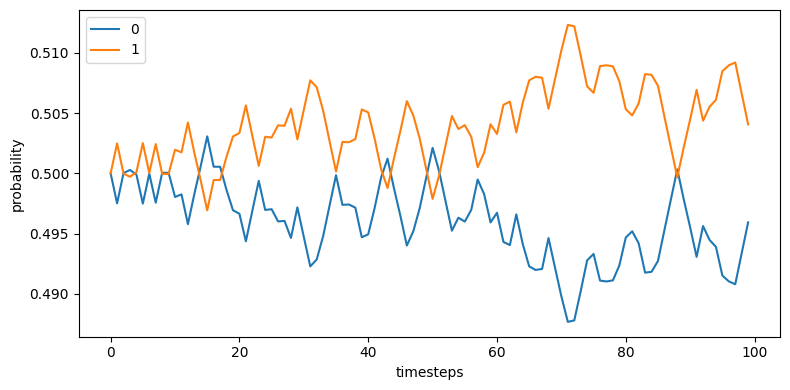

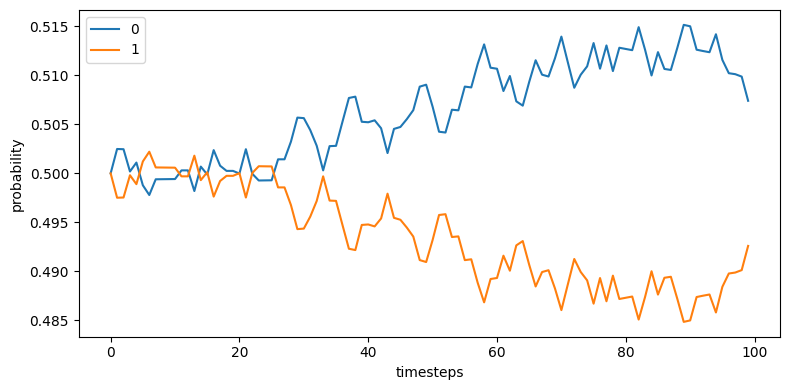

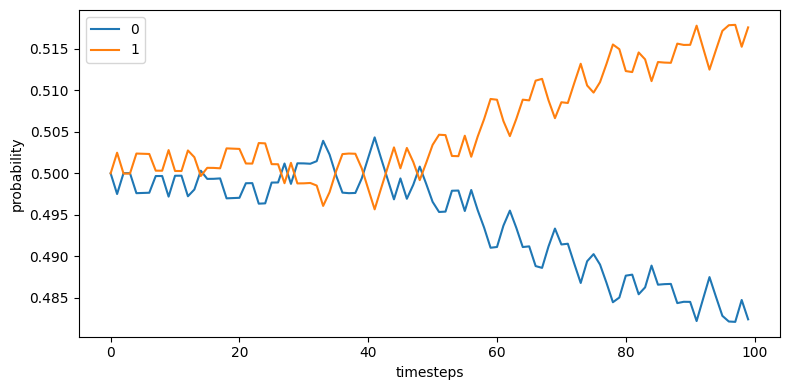

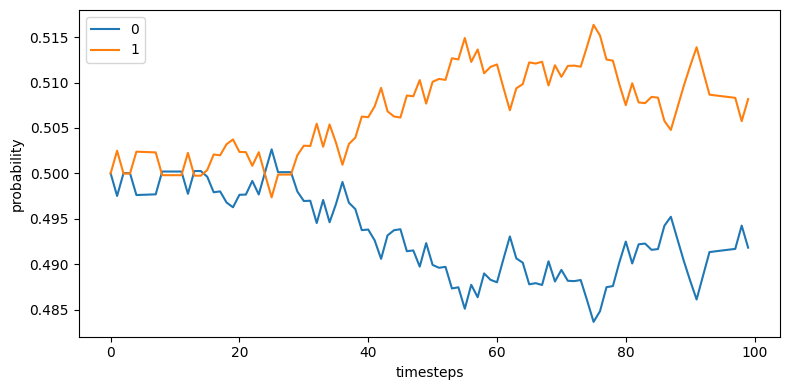

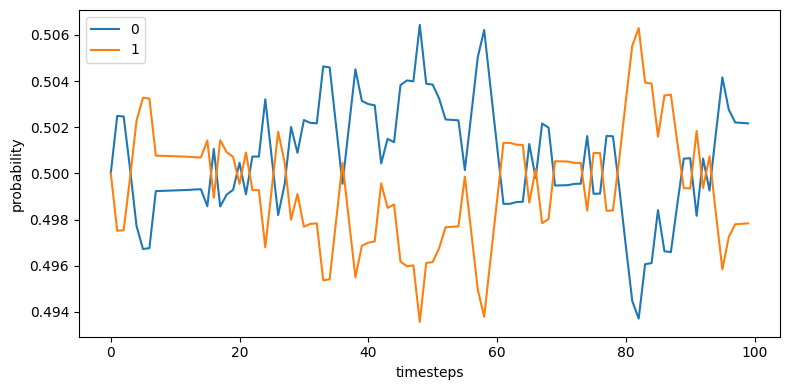

In [140]:
data = sim.predict(test_images[:200])

for i in range(5):
    plt.figure(figsize=(8, 4))
    plt.plot(tf.nn.softmax(data[out_p_filt][100 + i]))
    plt.legend([str(i) for i in range(10)], loc="upper left")
    plt.xlabel("timesteps")
    plt.ylabel("probability")
    plt.tight_layout()
    print(test_labels[100 + i, 0])